In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
sns.set()

In [2]:
URL = 'http://vfacstaff.ltu.edu/lshamir/data/assym/p_all_full.csv'
df = pd.read_csv(URL)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 455 entries, rotation to ID
dtypes: float64(383), int64(71), object(1)
memory usage: 46.7+ MB


I decided to drop NaN entries instead of imputing values. We only lost 3.6% of our overall data.

In [4]:
df.replace(-9999.00, np.nan, inplace=True)
df_dropped = df.dropna()
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12952 entries, 0 to 13439
Columns: 455 entries, rotation to ID
dtypes: float64(408), int64(46), object(1)
memory usage: 45.1+ MB


In [5]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_dropped.drop('rotation', axis=1), df_dropped['rotation'], 
                                                    random_state=42, stratify=df_dropped['rotation'])

First, we'll try logistic regression with the default parameters. Our score is 0.518, which is not great.

In [7]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5176034589252625

Let's tune the hyperparameter C using grid search cross validation. We arrive at the best value for C (0.001).

In [8]:
cv_model = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid={'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}, cv=5)
cv_model.fit(X_train, y_train)
cv_model.best_params_

{'C': 0.001}

Unfortunately, the cross validated model gave us the same score as the default model.

In [9]:
cv_model.score(X_test, y_test)

0.5176034589252625

The score for the training dataset is marginally better but not by much.

In [10]:
cv_model.score(X_train, y_train)

0.5184270125591929

We can plot the ROC curve. The AUC is 0.50, which is equivalent to a coin toss, so not great.

In [11]:
probs = cv_model.predict_proba(X_test)
probs = probs[:, 1]
no_skill = np.zeros(len(y_test))

In [12]:
tpr, fpr, thresh = roc_curve(y_test, probs, pos_label='cw')
ns_tpr, ns_fpr, ns_thresh = roc_curve(y_test, no_skill, pos_label='cw')

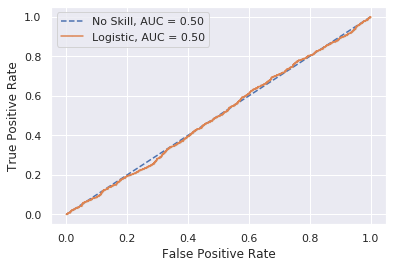

In [13]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %.2f' % auc(ns_fpr, ns_tpr))
plt.plot(fpr, tpr, marker='.', markersize=0.1, label='Logistic, AUC = %.2f' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Ignore these commented cells, I tried doing some feature reduction but the score ended up being even worse! I decided to try another approach.

In [14]:
'''from sklearn.feature_selection import RFE
feature_nums = [5, 10, 20, 30, 40, 50]
feature_results = []

for num in feature_nums:
    rfe_model = RFE(LogisticRegression(C=0.001, solver='lbfgs'), n_features_to_select=num).fit(X_train, y_train)
    feature_results.append((num, rfe_model.score(X_test, y_test)))

print(feature_results)'''

"from sklearn.feature_selection import RFE\nfeature_nums = [5, 10, 20, 30, 40, 50]\nfeature_results = []\n\nfor num in feature_nums:\n    rfe_model = RFE(LogisticRegression(C=0.001, solver='lbfgs'), n_features_to_select=num).fit(X_train, y_train)\n    feature_results.append((num, rfe_model.score(X_test, y_test)))\n\nprint(feature_results)"

In [15]:
'''rfe_model = RFE(LogisticRegression(C=0.001, solver='lbfgs'), n_features_to_select=5).fit(X_train, y_train)
rfe_model.ranking_'''

"rfe_model = RFE(LogisticRegression(C=0.001, solver='lbfgs'), n_features_to_select=5).fit(X_train, y_train)\nrfe_model.ranking_"

In [16]:
'''sig_features = []
for i, feat_rank in enumerate(rfe_model.ranking_):
    if feat_rank == 1:
        sig_features.append(X_train.columns[i])
    else:
        continue
sig_features.append('rotation')
sig_features'''

"sig_features = []\nfor i, feat_rank in enumerate(rfe_model.ranking_):\n    if feat_rank == 1:\n        sig_features.append(X_train.columns[i])\n    else:\n        continue\nsig_features.append('rotation')\nsig_features"

In [17]:
'''#sig_features = sig_features.append('rotation')
sig_df = df_dropped[sig_features]
sig_X = sig_df.drop('rotation', axis=1)
sig_y = sig_df['rotation']
#X_train, X_test, y_train, y_test = train_test_split(sig_df.drop('rotation', axis=1), sig_df['rotation'], 
#                                                   random_state=42, stratify=sig_df['rotation'])
'''

"#sig_features = sig_features.append('rotation')\nsig_df = df_dropped[sig_features]\nsig_X = sig_df.drop('rotation', axis=1)\nsig_y = sig_df['rotation']\n#X_train, X_test, y_train, y_test = train_test_split(sig_df.drop('rotation', axis=1), sig_df['rotation'], \n#                                                   random_state=42, stratify=sig_df['rotation'])\n"

My next model is a support vector machine. First, we will need to scale our features.

In [18]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df_dropped.drop('rotation', axis=1))
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, df_dropped['rotation'], 
                                                                  random_state=42, stratify=df_dropped['rotation'])

/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Our score (0.523) is a little better!

In [19]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42).fit(X_train_scaled, y_train)
svm_model.score(X_test_scaled, y_test)

/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5231624459542927

Plotting the ROC curve. Our AUC this time is 0.48. We are making progress, but in the opposite direction.

In [20]:
probs = svm_model.decision_function(X_test_scaled)
no_skill = np.zeros(len(y_test))

In [21]:
tpr, fpr, thresh = roc_curve(y_test, probs, pos_label='cw')
ns_tpr, ns_fpr, ns_thresh = roc_curve(y_test, no_skill, pos_label='cw')

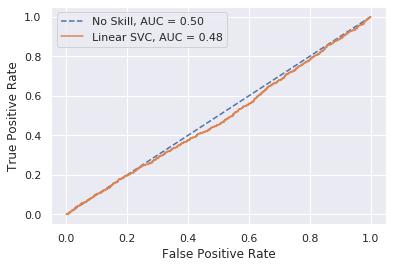

In [22]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %.2f' % auc(ns_fpr, ns_tpr))
plt.plot(fpr, tpr, marker='.', markersize=0.1, label='Linear SVC, AUC = %.2f' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()